In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [22]:
# load df
df = pd.read_pickle('/Users/assiachericoni/Documents/PYTHON/SimulationFinal/SimulationRandomExt30runs30rbfsFINAL.pkl')


In [23]:
df.head()
df.keys()

Index(['wtcorr_p', 'wtcorr_pv', 'wtcorr_pf', 'wtcorr_pvi', 'wtcorr_pif',
       'wtcorr_pvf', 'poscorr_p', 'poscorr_pv', 'poscorr_pf', 'poscorr_pvi',
       'poscorr_pif', 'poscorr_pvf', 'elbo_p', 'elbo_pv', 'elbo_pf',
       'elbo_pvi', 'elbo_pif', 'elbo_pvf', 'trial', 'gen_model', 'nrbfs',
       'gpscaler', 'runidx', 'real_gains', 'fit_gains', 'wtsim', 'hdi',
       'actual_shift', 'wtcorr_gen', 'poscorr_gen', 'elbo_gen', 'gaincorr_t1',
       'gaincorr_t2', 'gaincorr_all', 'run_idx', 'traj_real', 'traj_fit',
       'u_real', 'u_fit'],
      dtype='object')

In [24]:
df.shape

(5400, 39)

WHERE = start
Per-controller summary (mean r and % sims with p<0.05):
           mean_r_t1  mean_r_t2  pct_sig_t1  pct_sig_t2
gen_model                                              
p             -0.079     -0.261       6.667      30.000
pf            -0.257     -0.269      30.000      26.667
pif           -0.119     -0.109       3.333      20.000
pv            -0.014      0.171       0.000      10.000
pvf            0.228      0.282      16.667      46.667
pvi           -0.153      0.299       3.333      36.667


/var/folders/qc/0qp9qctj5fbf2t67dl9rjsgc0000gq/T/ipykernel_18923/3374149660.py:99: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = df.groupby([CTRL, SIM]).apply(corr_row).reset_index()


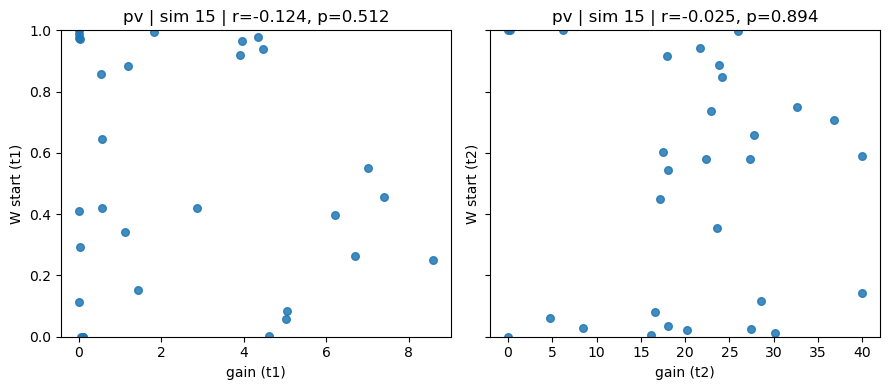

(# sig after FDR, total, min q):
('p', 'p_t1') (np.int64(1), 30, np.float64(0.014687378572186235))
('pf', 'p_t1') (np.int64(6), 30, np.float64(0.0006623033763736426))
('pif', 'p_t1') (np.int64(0), 30, np.float64(0.7332547277101309))
('pv', 'p_t1') (np.int64(0), 30, np.float64(0.8969267553118121))
('pvf', 'p_t1') (np.int64(2), 30, np.float64(0.03243273147804268))
('pvi', 'p_t1') (np.int64(0), 30, np.float64(0.4900108771981828))
('p', 'p_t2') (np.int64(1), 30, np.float64(0.03124809834274718))
('pf', 'p_t2') (np.int64(3), 30, np.float64(0.0014769171910242282))
('pif', 'p_t2') (np.int64(2), 30, np.float64(0.04797242915466372))
('pv', 'p_t2') (np.int64(0), 30, np.float64(0.10562982908140857))
('pvf', 'p_t2') (np.int64(6), 30, np.float64(0.0006047594168572016))
('pvi', 'p_t2') (np.int64(3), 30, np.float64(0.02138067376967762))


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection

# ====== CHOOSE: 'start' | 'mid' | 'end' ======
WHERE = 'start'
# ================================================

df = df.copy()
CTRL = 'gen_model'
SIM  = 'run_idx' if 'run_idx' in df.columns else 'runidx'

# --- helpers ---
def fit_gain_target(fitgains, target):
    """
    Extract a single scalar gain for target 1 or 2 from the 'fit_gains' cell.
    Assumes fit_gains looks like [L1_fit, L2_fit], where each can be a scalar
    or a 1D array/list. Returns NaN if missing.
    """
    idx = 0 if target == 1 else 1
    try:
        arr = np.asarray(fitgains[idx], dtype=float).ravel()
    except Exception:
        return np.nan
    return float(arr[0]) if arr.size else np.nan

def w_series_by_target(wtsim, target=1):
    """
    Return W(t) for the chosen target as a 1D array of length T,
    handling both (T,2) and (2,T) and degenerate (T,1)/(1,T)/(T,) shapes.
    """
    a = np.asarray(wtsim, dtype=float)

    if a.ndim == 1:
        w1 = a
        return w1 if target == 1 else 1.0 - w1

    if a.ndim == 2:
        # (2, T): rows = targets, cols = time
        if a.shape[0] == 2 and a.shape[1] > 2:
            return a[0, :] if target == 1 else a[1, :]
        # (T, 2): rows = time, cols = targets
        if a.shape[1] == 2 and a.shape[0] > 2:
            return a[:, 0] if target == 1 else a[:, 1]
        # (T,1)
        if a.shape[1] == 1:
            w1 = a[:, 0]
            return w1 if target == 1 else 1.0 - w1
        # (1,T)
        if a.shape[0] == 1:
            w1 = a[0, :]
            return w1 if target == 1 else 1.0 - w1

    # Fallback: flatten as single series (assume it's W1)
    w1 = a.reshape(-1)
    return w1 if target == 1 else 1.0 - w1


def w_value(wtsim, target=1, where='mid'):
    """
    Pick a single W value (no averaging) at 'start' | 'mid' | 'end'
    using a robust series extractor that handles (2,T) and (T,2).
    """
    w = w_series_by_target(wtsim, target=target)
    if w.size == 0:
        return np.nan
    if where == 'start':
        idx = 0
    elif where == 'end':
        idx = -1
    elif where == 'mid':
        idx = w.size // 2
    else:
        raise ValueError("where must be 'start', 'mid', or 'end'")
    return float(w[idx])
def r_p(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    x = x[m]; y = y[m]
    if x.size < 3 or np.allclose(x, x[0]) or np.allclose(y, y[0]):
        return np.nan, np.nan
    r, p = pearsonr(x, y)
    return float(r), float(p)

# --- build per-trial features (OVERWRITE to avoid stale values) ---
df['g_t1'] = df['fit_gains'].apply(lambda g: fit_gain_target(g, 1))
df['g_t2'] = df['fit_gains'].apply(lambda g: fit_gain_target(g, 2))
df['W_t1'] = df['wtsim'].apply(lambda w: w_value(w, 1, WHERE))
df['W_t2'] = df['wtsim'].apply(lambda w: w_value(w, 2, WHERE))

# --- correlations per controller × simulation (across the 30 trials) ---
def corr_row(g):
    r1, p1 = r_p(g['g_t1'].values, g['W_t1'].values)
    r2, p2 = r_p(g['g_t2'].values, g['W_t2'].values)
    return pd.Series({'where': WHERE, 'r_t1': r1, 'p_t1': p1, 'r_t2': r2, 'p_t2': p2, 'n': len(g)})

stats = df.groupby([CTRL, SIM]).apply(corr_row).reset_index()

# --- summary per controller ---
summary = (
    stats.groupby(CTRL)
         .agg(mean_r_t1=('r_t1','mean'),
              mean_r_t2=('r_t2','mean'),
              pct_sig_t1=('p_t1', lambda p: 100*np.mean(p < 0.05)),
              pct_sig_t2=('p_t2', lambda p: 100*np.mean(p < 0.05)))
         .round(3)
)
print(f"WHERE = {WHERE}")
print("Per-controller summary (mean r and % sims with p<0.05):")
print(summary)

# --- example scatter for one controller/sim using the chosen WHERE ---
ex_ctrl, ex_sim = 'pv', 15
g = df[(df[CTRL]==ex_ctrl) & (df[SIM]==ex_sim)]
r1, p1 = r_p(g['g_t1'], g['W_t1'])
r2, p2 = r_p(g['g_t2'], g['W_t2'])

fig, ax = plt.subplots(1,2, figsize=(9,4), sharey=True)
ax[0].scatter(g['g_t1'], g['W_t1'], s=30, alpha=0.85)
ax[0].set_xlabel('gain (t1)'); ax[0].set_ylabel(f"W {WHERE} (t1)"); ax[0].set_ylim(0,1)
ax[0].set_title(f'{ex_ctrl} | sim {ex_sim} | r={r1:.3f}, p={p1:.3g}')
ax[1].scatter(g['g_t2'], g['W_t2'], s=30, alpha=0.85)
ax[1].set_xlabel('gain (t2)'); ax[1].set_ylabel(f"W {WHERE} (t2)"); ax[1].set_ylim(0,1)
ax[1].set_title(f'{ex_ctrl} | sim {ex_sim} | r={r2:.3f}, p={p2:.3g}')
plt.tight_layout(); plt.show()

# --- FDR across simulations per controller (per target) ---
out = {}
for t in ['p_t1','p_t2']:
    for ctrl, sub in stats.groupby(CTRL):
        m = sub[t].notna()
        reject, q = fdrcorrection(sub.loc[m, t].values, alpha=0.05)
        out[(ctrl, t)] = (reject.sum(), len(q), (q.min() if len(q) else None))
        stats.loc[sub.index[m], t.replace('p_','q_')] = q

print('(# sig after FDR, total, min q):')
for k, v in out.items():
    print(k, v)


In [47]:
import numpy as np
from scipy.stats import norm

def r_ci(r, n, alpha=0.05):
    z = np.arctanh(np.clip(r, -0.999999, 0.999999))
    se = 1/np.sqrt(n-3)
    zc = norm.ppf(1-alpha/2)
    return np.tanh(z - zc*se), np.tanh(z + zc*se)

stats['n'] = 30  # trials per sim
stats[['rlo_t1','rhi_t1']] = stats.apply(lambda s: r_ci(s['r_t1'], s['n']), axis=1, result_type='expand')
stats[['rlo_t2','rhi_t2']] = stats.apply(lambda s: r_ci(s['r_t2'], s['n']), axis=1, result_type='expand')


In [48]:
stats

,gen_model,run_idx,where,r_t1,p_t1,r_t2,p_t2,n,q_t1,q_t2,rlo_t1,rhi_t1,rlo_t2,rhi_t2
0,p,1,start,-0.310499,0.094924,-0.361169,0.049890,30,0.474622,0.166299,-0.603283,0.056039,-0.638374,-0.001034
1,p,2,start,-0.334312,0.070973,-0.258872,0.167177,30,0.458001,0.301992,-0.619917,0.029511,-0.566324,0.111827
2,p,3,start,-0.222447,0.237407,-0.461364,0.010281,30,0.712220,0.119735,-0.539481,0.149830,-0.704530,-0.121248
3,p,4,start,-0.190664,0.312863,-0.309714,0.095807,30,0.753171,0.261292,-0.515522,0.182115,-0.602730,0.056905
4,p,5,start,0.053782,0.777741,0.229782,0.221891,30,0.934544,0.332837,-0.312543,0.406181,-0.142265,0.544939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,pvi,26,start,-0.202109,0.284141,0.575257,0.000882,30,0.490011,0.021381,-0.524209,0.170580,0.271192,0.774925
176,pvi,27,start,-0.301431,0.105500,0.071246,0.708310,30,0.490011,0.787011,-0.596881,0.066007,-0.296637,0.420717
177,pvi,28,start,-0.104850,0.581352,0.376293,0.040415,30,0.670791,0.121245,-0.448190,0.265446,0.018536,0.648629
178,pvi,29,start,-0.373592,0.041992,0.448862,0.012845,30,0.490011,0.074891,-0.646805,-0.015395,0.105682,0.696499


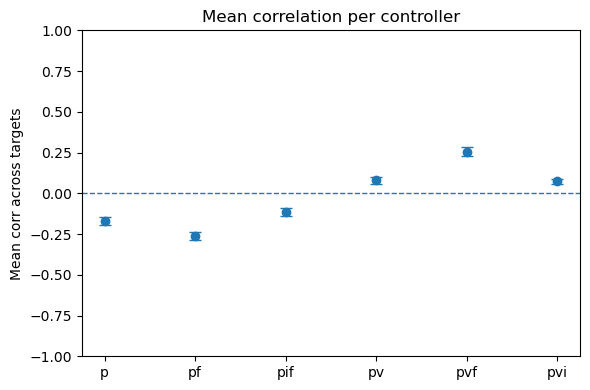

           mean_r   se_r   n
gen_model                   
p          -0.170  0.026  30
pf         -0.263  0.025  30
pif        -0.114  0.023  30
pv          0.079  0.023  30
pvf         0.255  0.027  30
pvi         0.073  0.016  30


In [49]:
# Per-simulation mean across targets
stats['r_mean'] = stats[['r_t1','r_t2']].mean(axis=1)  # skipna=True by default

# Aggregate over simulations per controller
by_ctrl = (
    stats.groupby(CTRL)['r_mean']
         .agg(['mean','std','count'])
         .rename(columns={'mean':'mean_r', 'std':'sd_r', 'count':'n'})
)
by_ctrl['se_r'] = by_ctrl['sd_r'] / np.sqrt(by_ctrl['n'])


controllers = by_ctrl.index.to_list()
x = np.arange(len(controllers))
y = by_ctrl['mean_r'].to_numpy()
yerr = by_ctrl['se_r'].to_numpy()

plt.figure(figsize=(6,4))
plt.plot(x, y, 'o')
plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=4, linewidth=1)
plt.axhline(0, linestyle='--', linewidth=1)
plt.xticks(x, controllers)
plt.ylabel('Mean corr across targets')
plt.title('Mean correlation per controller')
plt.ylim(-1, 1)
plt.tight_layout()
save_path = "/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData/figures_cumulative/identifiabilityProblem/identifiability30RandomExtMeanStart.svg"
plt.savefig(save_path, format='svg', bbox_inches='tight')

plt.show()
print(by_ctrl[['mean_r','se_r','n']].round(3))


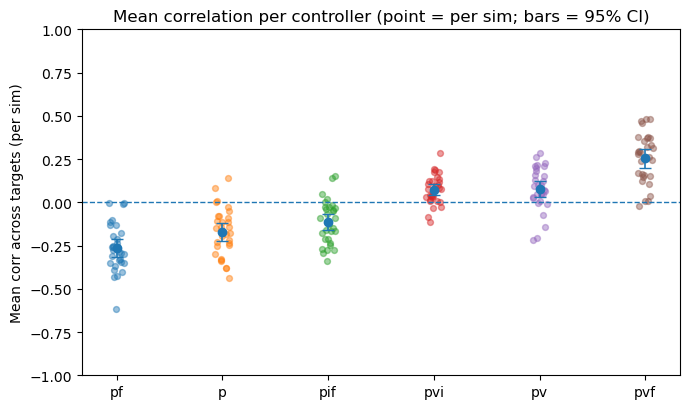

Per-controller mean ± 95% CI:
           mean_r  ci_lo  ci_hi   n
gen_model                          
pf         -0.263 -0.315 -0.211  30
p          -0.170 -0.223 -0.117  30
pif        -0.114 -0.161 -0.067  30
pvi         0.073  0.041  0.106  30
pv          0.079  0.032  0.126  30
pvf         0.255  0.201  0.309  30

One-sample t-tests vs 0 with FDR across controllers:
            n       t      p  reject      q
gen_model                                  
pf         30 -10.369  0.000    True  0.000
p          30  -6.621  0.000    True  0.000
pif        30  -4.920  0.000    True  0.000
pvi        30   4.613  0.000    True  0.000
pv         30   3.419  0.002    True  0.002
pvf        30   9.588  0.000    True  0.000


In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_1samp, t
from statsmodels.stats.multitest import fdrcorrection

# 1) per-sim mean across targets
stats = stats.copy()
stats['r_mean'] = stats[['r_t1','r_t2']].mean(axis=1)

# 2) 95% CI per controller
agg = (stats.groupby('gen_model')['r_mean']
             .agg(['mean','std','count'])
             .rename(columns={'mean':'mean_r','std':'sd_r','count':'n'}))
agg['se_r'] = agg['sd_r'] / np.sqrt(agg['n'])
tcrit = t.ppf(0.975, df=agg['n']-1)
agg['ci_lo'] = agg['mean_r'] - tcrit * agg['se_r']
agg['ci_hi'] = agg['mean_r'] + tcrit * agg['se_r']

# 3) one-sample t-tests vs 0 + FDR across controllers
tests = []
for ctrl, sub in stats.groupby('gen_model'):
    r = sub['r_mean'].dropna()
    tstat, p = ttest_1samp(r, 0.0)
    tests.append((ctrl, len(r), tstat, p))
tests = pd.DataFrame(tests, columns=['gen_model','n','t','p'])
tests['reject'], tests['q'] = fdrcorrection(tests['p'].values, alpha=0.05)

# 4) plot: per-sim dots + mean with 95% CI
order = agg['mean_r'].sort_values().index.tolist()
x = np.arange(len(order))

plt.figure(figsize=(7,4.2))

# per-sim dots
for i, ctrl in enumerate(order):
    y = stats.loc[stats['gen_model']==ctrl, 'r_mean']
    jitter = (np.random.rand(len(y)) - 0.5) * 0.15
    plt.scatter(np.full(len(y), i) + jitter, y, alpha=0.45, s=18)

# means with 95% CI
plt.errorbar(x, agg.loc[order, 'mean_r'],
             yerr=[agg.loc[order, 'mean_r'] - agg.loc[order, 'ci_lo'],
                   agg.loc[order, 'ci_hi'] - agg.loc[order, 'mean_r']],
             fmt='o', capsize=4, linewidth=1.2, markersize=6, zorder=5)

plt.axhline(0, ls='--', lw=1)
plt.xticks(x, order)
plt.ylabel('Mean corr across targets (per sim)')
plt.title('Mean correlation per controller (point = per sim; bars = 95% CI)')
plt.ylim(-1, 1)
plt.tight_layout()
save_path = "/Users/assiachericoni/Documents/PYTHON/ControllerModeling-main_old/PacManData/figures_cumulative/identifiabilityProblem/identifiability30RandomExtStart.svg"
plt.savefig(save_path, format='svg', bbox_inches='tight')

plt.show()

print("Per-controller mean ± 95% CI:")
print(agg.loc[order, ['mean_r','ci_lo','ci_hi','n']].round(3))
print("\nOne-sample t-tests vs 0 with FDR across controllers:")
print(tests.set_index('gen_model').loc[order].round(3))


In [51]:
import numpy as np
import pandas as pd

# --- helpers to get TRUE values per trial ---
def true_gain_target(real_gains, target):
    idx = 0 if target == 1 else 1
    try:
        arr = np.asarray(real_gains[idx], dtype=float).ravel()
        return float(arr[0]) if arr.size else np.nan
    except Exception:
        return np.nan

def true_w_value(actual_shift, target, where='mid'):
    return w_value(actual_shift, target=target, where=where)  # uses your robust extractor

# build per-trial true vs estimated features (overwrite to be safe)
df['g_true_t1'] = df['real_gains'].apply(lambda rg: true_gain_target(rg, 1))
df['g_true_t2'] = df['real_gains'].apply(lambda rg: true_gain_target(rg, 2))
df['w_true_t1'] = df['actual_shift'].apply(lambda a: true_w_value(a, 1, WHERE))
df['w_true_t2'] = df['actual_shift'].apply(lambda a: true_w_value(a, 2, WHERE))

df['g_hat_t1']  = df['fit_gains'].apply(lambda g: fit_gain_target(g, 1))
df['g_hat_t2']  = df['fit_gains'].apply(lambda g: fit_gain_target(g, 2))
df['w_hat_t1']  = df['wtsim'].apply(lambda w: w_value(w, 1, WHERE))
df['w_hat_t2']  = df['wtsim'].apply(lambda w: w_value(w, 2, WHERE))

# basic correlation helper
def safe_r(x, y):
    x = np.asarray(x, float); y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 3 or np.allclose(x[m], x[m][0]) or np.allclose(y[m], y[m][0]):
        return np.nan
    return float(np.corrcoef(x[m], y[m])[0,1])

# Fisher z-combo
def fisher_mean(r1, r2):
    if np.isnan(r1) or np.isnan(r2): return np.nan
    return float(np.tanh(0.5*(np.arctanh(np.clip(r1,-0.999999,0.999999)) +
                               np.arctanh(np.clip(r2,-0.999999,0.999999)))))

# 2D canonical correlation between true and estimated (for a single target k)
def cca2d(true_xy, hat_xy):
    # true_xy, hat_xy: arrays shape (N,2) with columns [w, g]
    X = np.asarray(true_xy, float); Y = np.asarray(hat_xy, float)
    m = np.all(np.isfinite(X), axis=1) & np.all(np.isfinite(Y), axis=1)
    X = X[m]; Y = Y[m]
    if len(X) < 3: return np.nan
    # center
    X -= X.mean(0); Y -= Y.mean(0)
    # whiten
    def whiten(A):
        C = np.cov(A, rowvar=False)
        # regularize tiny diagonals
        u,s,vh = np.linalg.svd(C, full_matrices=False)
        W = u @ np.diag(1/np.sqrt(np.maximum(s, 1e-12))) @ u.T
        return A @ W
    Xw = whiten(X); Yw = whiten(Y)
    # first canonical corr = largest singular value of corr matrix
    U, s, Vh = np.linalg.svd(Xw.T @ Yw / (len(Xw)-1), full_matrices=False)
    return float(np.clip(s[0], 0, 1))

# compute per controller × sim × target
CTRL = 'gen_model'
SIM  = 'run_idx' if 'run_idx' in df.columns else 'runidx'

def joint_metrics(group, tgt):
    w_true = group[f'w_true_t{tgt}'].values
    g_true = group[f'g_true_t{tgt}'].values
    w_hat  = group[f'w_hat_t{tgt}'].values
    g_hat  = group[f'g_hat_t{tgt}'].values

    # per-parameter recovery
    r_w = safe_r(w_true, w_hat)
    r_g = safe_r(g_true, g_hat)
    # joint scores
    r_joint = fisher_mean(r_w, r_g)
    rho_cca = cca2d(np.c_[w_true, g_true], np.c_[w_hat, g_hat])

    # interdependence among estimates (optional)
    r_hat_cross = safe_r(w_hat, g_hat)

    return pd.Series({
        f'r_w_t{tgt}': r_w, f'r_g_t{tgt}': r_g,
        f'r_joint_fisher_t{tgt}': r_joint,
        f'rho_cca_t{tgt}': rho_cca,
        f'r_hat_cross_t{tgt}': r_hat_cross,
        'n': len(group)
    })

joint = (
    df.groupby([CTRL, SIM])
      .apply(lambda g: pd.concat([
          joint_metrics(g, 1),
          joint_metrics(g, 2)
      ]))
      .reset_index()
)

# summarize per controller
summary = (
    joint.groupby(CTRL)
         .agg({
             'r_w_t1':'mean','r_g_t1':'mean','r_joint_fisher_t1':'mean','rho_cca_t1':'mean',
             'r_w_t2':'mean','r_g_t2':'mean','r_joint_fisher_t2':'mean','rho_cca_t2':'mean',
             'r_hat_cross_t1':'mean','r_hat_cross_t2':'mean'
         })
         .round(3)
)
print(f'WHERE = {WHERE}')
print('Joint recovery summary per controller (means over sims):')
print(summary)


WHERE = start
Joint recovery summary per controller (means over sims):
           r_w_t1  r_g_t1  r_joint_fisher_t1  rho_cca_t1  r_w_t2  r_g_t2  \
gen_model                                                                  
p           0.726   0.111              0.489       0.768   0.726   0.158   
pf          0.380  -0.013              0.193       0.468   0.380  -0.020   
pif         0.232  -0.037              0.101       0.370   0.232  -0.006   
pv          0.732  -0.042              0.428       0.762   0.732   0.072   
pvf         0.727   0.086              0.472       0.772   0.727   0.048   
pvi         0.664   0.041              0.406       0.695   0.664  -0.042   

           r_joint_fisher_t2  rho_cca_t2  r_hat_cross_t1  r_hat_cross_t2  
gen_model                                                                 
p                      0.502       0.799          -0.079          -0.261  
pf                     0.190       0.493          -0.257          -0.269  
pif                 

/var/folders/qc/0qp9qctj5fbf2t67dl9rjsgc0000gq/T/ipykernel_18923/317406676.py:92: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.concat([
